In [27]:
IDENTIFIER = "haydn-op1"
NUM = 2

picklePath = f"../Pickles/{IDENTIFIER}/{IDENTIFIER}_"
numPath = f"../Pickles/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"
dataPath = f"../Data/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"

import pandas as pd
import json
import networkx as nx
import numpy as np
import itertools as iter
import matplotlib.pyplot as plt
from dwave.system import DWaveSampler, FixedEmbeddingComposite

from qubo import createBQM
from samples import duplicates, overlaps
from plots import plotCSV


phrases = pd.read_csv(picklePath + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(picklePath + "graph.graphml")
instruments = json.load(open(numPath + "instruments.json"))
embedding = json.load(open(numPath + "embedding.json", "r"))

sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)

## Pegasus topology

- Each qubit coupled to 15 other qubits
- 5640 qubits in one QPU

Due to limitations with QPU size could only pick shortish pieces/cut pieces short.

In [ ]:
print(len(phrases))
print(sum(len(embedding[i]) for i in embedding))

193
2912


In [28]:
# Node constraint

multipliers = iter.product(range(1,10), range(1,10))
reads = 2000

file = pd.DataFrame()

for n, e in multipliers:
    bqm = createBQM(G, phrases, instruments, n, e, 1)
    sampleset = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}")
    sample = sampleset.first

    new_row = pd.DataFrame({
        "Node multiplier": [n],
        "Edge multiplier": [e],
        "Lowest energy": [bqm.energy(sample.sample)],
        "Chain break fraction": [sample.chain_break_fraction],
        "Duplicates": [duplicates(sample.sample, G)],
        "Overlaps": [overlaps(sample.sample, G)]
        })
    
    file = pd.concat([file, new_row])
    
    print(f"Recorded node multplier {n} and edge multiplier {e}!")

file.to_csv(dataPath+"lagrange.csv", index=False, mode="a", header=False)

Recorded node multplier 1 and edge multiplier 1!
Recorded node multplier 1 and edge multiplier 2!
Recorded node multplier 1 and edge multiplier 3!
Recorded node multplier 1 and edge multiplier 4!
Recorded node multplier 1 and edge multiplier 5!
Recorded node multplier 1 and edge multiplier 6!
Recorded node multplier 1 and edge multiplier 7!
Recorded node multplier 1 and edge multiplier 8!
Recorded node multplier 1 and edge multiplier 9!
Recorded node multplier 2 and edge multiplier 1!
Recorded node multplier 2 and edge multiplier 2!
Recorded node multplier 2 and edge multiplier 3!
Recorded node multplier 2 and edge multiplier 4!
Recorded node multplier 2 and edge multiplier 5!
Recorded node multplier 2 and edge multiplier 6!
Recorded node multplier 2 and edge multiplier 7!
Recorded node multplier 2 and edge multiplier 8!
Recorded node multplier 2 and edge multiplier 9!
Recorded node multplier 3 and edge multiplier 1!
Recorded node multplier 3 and edge multiplier 2!
Recorded node multpl

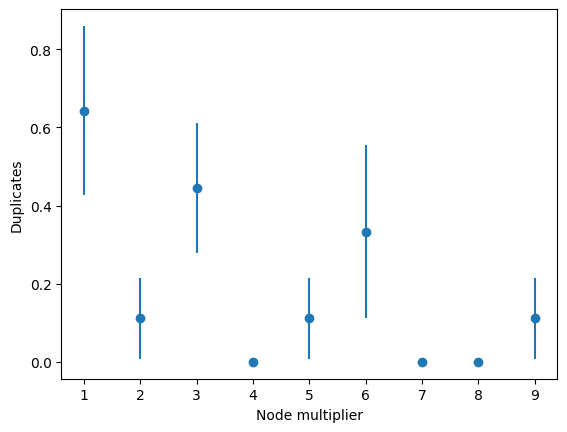

In [26]:
plotCSV(dataPath+"lagrange.csv", "Node multiplier", "Duplicates")

Text(0.5, 0, 'Broken constraints')

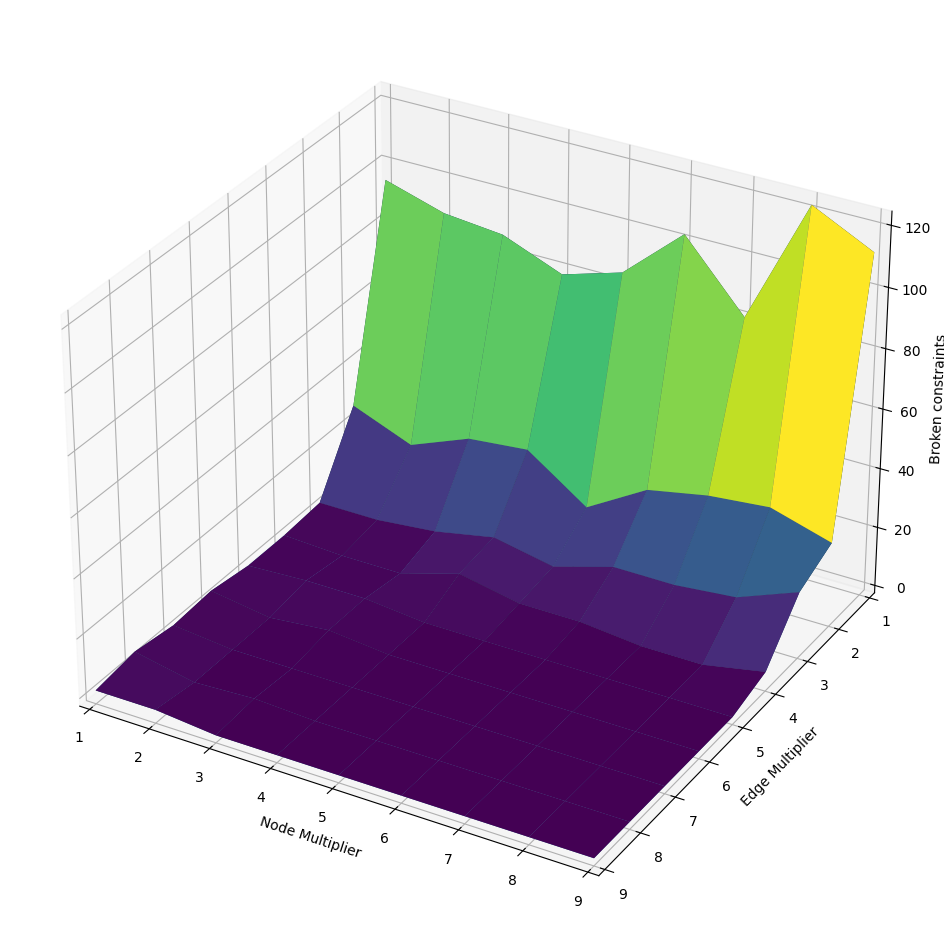

In [30]:
data = pd.read_csv(dataPath + "lagrange.csv")

grouped = (
    data.groupby(["Node multiplier", "Edge multiplier"])
    .mean(numeric_only=True)
    .reset_index()
)

grouped["Broken"] = grouped["Overlaps"] + grouped["Duplicates"]

# Extract unique X and Y values
x = grouped["Node multiplier"].unique()
y = grouped["Edge multiplier"].unique()

x , y = np.meshgrid(x, y)
z = grouped.pivot(index="Edge multiplier", columns="Node multiplier", values="Broken").values

# Creating plot

fig = plt.figure(figsize =(12, 12))
ax = plt.axes(projection ='3d')
ax.plot_surface(x, y, z)

ax.plot_surface(x, y, z, cmap='viridis')

#ax.view_init(elev=30, azim=45)

ax.set_xlim(1, 9)
ax.set_ylim(9, 1)
# Add labels
ax.set_xlabel("Node Multiplier")
ax.set_ylabel("Edge Multiplier")
ax.set_zlabel("Broken constraints")